# Previsões para colheitas de 2020 via Regressão Logística One-vs-Rest e SMOTE
### Renato Júnior Moreira e Silva

Neste pequeno projeto*, utilizei os datasets disponibilizados pela empresa Scicrop para realizar a previsão de saúde/qualidade de colheitas em safras de 2020 utilizando uma classificação em 3 classes:

0 - Colheita Saudável

1 - Colheita sofreu danos por motivos diversos

2 - Colheita sofreu dano por pesticidas

A estratégia utilizada foi a de tomar uma regressão logística multiclasse via one-vs-rest e o principal obstáculo foi a de exemplos desbalanceados e utilizei o algoritmo SMOTE para sintetizar novos exemplos de classes minoritarias.

\* Projeto realizado como parte de um processo seletivo da Scicrop

## Lendo e limpando as Tabelas das Safras de 2018-2019, 2020


In [533]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#Primeiramente, vamos ler a Safra de Treino e retirar os missing values da tabela
safra_treino=pd.read_csv("Safra_2018-2019.csv")
safra_treino=safra_treino.dropna()

#Agora, vamos ler a Safra para previsão:
safra_prev=pd.read_csv("Safra_2020.csv")
safra_prev=safra_prev.dropna()

In [534]:
#Vamos conhecer um pouco do formato e da tabela de dados:

print(safra_treino.shape)
safra_treino.head()

(71945, 11)


,Unnamed: 0,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
0,0,SCROP00001,188,1,0,1,0,0.0,0,1,0
1,1,SCROP00002,209,1,0,1,0,0.0,0,2,1
2,2,SCROP00003,257,1,0,1,0,0.0,0,2,1
3,3,SCROP00004,257,1,1,1,0,0.0,0,2,1
4,4,SCROP00005,342,1,0,1,0,0.0,0,2,1


## Visualizando os dados das safras e indexando os dataframes

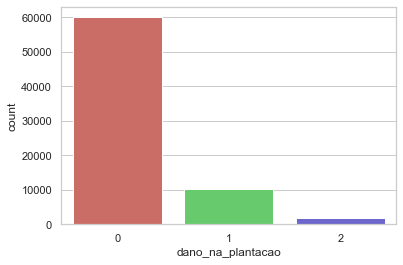

In [535]:
#Vamos explorar um pouco dos dados. Observemos a distribuição de resultados da colheita:
safra_treino['dano_na_plantacao'].value_counts()

#Plotamos também um gráfico ilustrando esta distribuição e vemos que há um nítido desbalanço
#na quantidade de colheitas saudáveis e colheitas não-saudáveis:
sns.countplot(x='dano_na_plantacao',data=safra_treino,palette='hls')
plt.show()

In [536]:
#Vamos restringir nosso dataframe aos dados que utilizaremos na regressão:
safra_treino=safra_treino.reset_index()
safra_treino=safra_treino.drop(columns=['Unnamed: 0','Identificador_Agricultor'])

#Repetimos o feito acima para a safra de 2020:
safra_prev=safra_prev.reset_index()
safra_prev=safra_prev.drop(columns=['Unnamed: 0','Identificador_Agricultor'])

## Resolvendo o problema de desbalanço de exemplos com SMOTE; dividindo os sets de treino e teste

In [537]:
#Vamos dividir nosso training set. Primeiramente, definimos X e y:
X = safra_treino.loc[:, safra_treino.columns != 'dano_na_plantacao']
y = safra_treino.loc[:, safra_treino.columns == 'dano_na_plantacao']

#Performamos um feature scaling:
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)

#Lidamos com variáveis categóricas usando one-hot-encoding:
X['Categoria_Pesticida'] = pd.get_dummies(X.Categoria_Pesticida, prefix='Categoria')
X['Temporada'] = pd.get_dummies(X.Temporada, prefix='Temporada')
X['Tipo_de_Cultivo'] = pd.get_dummies(X.Temporada, prefix='Tipo_de_Cultivo')
X['Tipo_de_Solo'] = pd.get_dummies(X.Temporada, prefix='Tipo_de_Solo')



In [538]:
#Agora, utilizaremos o SMOTE para consertar o desbalanço entre os exemplos de treino. 
#Decompomos nosso set de treinamento em 3 subsets: um de cross-validation, um de treino e um de teste
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

bal=SMOTE(random_state=2)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=0)
X_cv, X_t, y_cv, y_t =  train_test_split(X, y, test_size=0.5, random_state=0)

columns = X_treino.columns

bal_X,bal_y = bal.fit_sample(X_treino, y_treino)
bal_X=pd.DataFrame(data=bal_X,columns=columns )
bal_y=pd.DataFrame(data=bal_y,columns=['dano_na_plantacao'])

#Checamos o balanço feito nos dados de teste:
print("Quantidade de novos dados balanceados: ",len(bal_X))
print("Quantidade de colheitas saudáveis dentre os novos dados balanceados:",
      len(bal_y[bal_y['dano_na_plantacao']==0]))
print("Quantidade de colheitas com danos causados por outros motivos dentre os novos dados balanceados:",
      len(bal_y[bal_y['dano_na_plantacao']==1]))
print("Quantidade de colheitas com danos causados por inseticidas dentre os novos dados balanceados:",
      len(bal_y[bal_y['dano_na_plantacao']==2]))

Quantidade de novos dados balanceados:  125934
Quantidade de colheitas saudáveis dentre os novos dados balanceados: 41978
Quantidade de colheitas com danos causados por outros motivos dentre os novos dados balanceados: 41978
Quantidade de colheitas com danos causados por inseticidas dentre os novos dados balanceados: 41978


## Aplicando o algoritmo de Regressão Logística One-vs-Rest e estudando acurácia, confusion matrix e F_1-score no set de Cross Validation

Começamos aplicando nosso modelo de regressão no set de Cross-Validation para que possamos escolhar o valor do parâmetro C de regularização. (Ao usar o set de teste para escolher os parâmetros, poderíamos enviesar nossos resultados)

In [539]:
#Aplicamos regressão logística usando o algoritmo One-vs-rest:
from sklearn.linear_model import LogisticRegression

modelo_1 = LogisticRegression(C=0.0000001, max_iter=10000,multi_class='ovr')
modelo_1.fit(bal_X, bal_y.values.ravel())

LogisticRegression(C=1e-07, max_iter=10000, multi_class='ovr')

In [540]:
#Vamos checar a acurácia no set de cross-validation:
from sklearn import metrics
y_pred = modelo_1.predict(X_cv)
print('A acurácia do algoritmo de regressão logística multiclasses no set de cross-validation é: {:.2f}'
      .format(metrics.accuracy_score(y_cv, y_pred,normalize=True, sample_weight=None)))

A acurácia do algoritmo de regressão logística multiclasses no set de cross-validation é: 0.62


In [541]:
#Calculamos a confusion matrix:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_cv, y_pred)
print(confusion_matrix)

[[20793  2555  6679]
 [ 1861   781  2354]
 [  269    83   597]]


In [542]:
#Verificamos os F_1-score macro e weighted:
from sklearn.metrics import f1_score
f1w=f1_score(y_cv,y_pred,average='weighted')
f1m=f1_score(y_cv,y_pred,average='micro')
print('Os F_1-Score weighted e micro são, respectivamente, {:.2f} e {:.2f} para o set de cross-validation'.format(f1w,f1m))

Os F_1-Score weighted e micro são, respectivamente, 0.68 e 0.62 para o set de cross-validation


Concluímos que o algoritmo construído **ainda** não possui razoável efetividade para previsões, mesmo no set de cross-validation. Realizaremos a **adição de variáveis polinomiais**!

## Novas features polinomiais - Aumentando a efetividade de nosso algoritmo

In [543]:
#Performamos um feature scaling:
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)

#Lidamos com variáveis categóricas usando one-hot-encoding:
X['Categoria_Pesticida'] = pd.get_dummies(X.Categoria_Pesticida, prefix='Categoria')
X['Temporada'] = pd.get_dummies(X.Temporada, prefix='Temporada')
X['Tipo_de_Cultivo'] = pd.get_dummies(X.Temporada, prefix='Tipo_de_Cultivo')
X['Tipo_de_Solo'] = pd.get_dummies(X.Temporada, prefix='Tipo_de_Solo')


In [544]:
#Adicionaremos features polinomiais a partir das features já disponibilizadas:
X['Insetos ao quadrado']=X['Estimativa_de_Insetos']**2
X['Insetos ao cubo']=X['Estimativa_de_Insetos']**3
X['Insetos a quarta']=X['Estimativa_de_Insetos']**4
X['Insetos a quinta']=X['Estimativa_de_Insetos']**5

X['Doses ao quadrado']=X['Doses_Semana']**2
X['Doses ao cubo']=X['Doses_Semana']**3
X['Doses a quarta']=X['Doses_Semana']**4
X['Doses a quinta']=X['Doses_Semana']**5

X['Doses e Insetos']=np.multiply(X['Doses_Semana']**2,X['Estimativa_de_Insetos'])

#Agora, utilizaremos o SMOTE para consertar o desbalanço entre os exemplos de treino.
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

bal=SMOTE(random_state=2)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=0)
X_cv, X_t, y_cv, y_t =  train_test_split(X, y, test_size=0.5, random_state=0)
columns = X_treino.columns

bal_X,bal_y = bal.fit_sample(X_treino, y_treino)
bal_X=pd.DataFrame(data=bal_X,columns=columns )
bal_y=pd.DataFrame(data=bal_y,columns=['dano_na_plantacao'])

## Testando nosso novo modelo no set de Cross-Validation:

In [545]:
#Aplicamos regressão logística usando o algoritmo One-vs-rest:
from sklearn.linear_model import LogisticRegression

modelo = LogisticRegression(C=0.00000001, max_iter=10000,multi_class='ovr')
modelo.fit(bal_X, bal_y.values.ravel())

LogisticRegression(C=1e-08, max_iter=10000, multi_class='ovr')

In [546]:
#Vamos checar a acurácia no set de cross-validation:
from sklearn import metrics
y_pred = modelo.predict(X_cv)
print('A acurácia do algoritmo de regressão logística multiclasses no set de cross-validation é: {:.2f}'
      .format(metrics.accuracy_score(y_cv, y_pred,normalize=True, sample_weight=None)))

A acurácia do algoritmo de regressão logística multiclasses no set de cross-validation é: 0.78


In [547]:
#Calculamos a confusion matrix:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_cv, y_pred)
print(confusion_matrix)

[[27070  1926  1031]
 [ 3644   890   462]
 [  726   120   103]]


In [548]:
#Verificamos os F_1-score macro e weighted:
from sklearn.metrics import f1_score
f1w=f1_score(y_cv,y_pred,average='weighted')
f1m=f1_score(y_cv,y_pred,average='micro')

print('Os F_1-Score weighted e micro são, respectivamente, {:.2f} e {:.2f}'.format(f1w,f1m))

Os F_1-Score weighted e micro são, respectivamente, 0.77 e 0.78


E desse modo, obtivemos uma melhora **substancial** na efetividade de nosso algoritmo: de 62% de acurácia para 78% e com melhora significativa no F_1-Score.

## Aplicando nosso modelo no set de teste:

In [549]:
from sklearn import metrics
y_pred = modelo.predict(X_t)
print('A acurácia do algoritmo de regressão logística multiclasses no set de teste é: {:.2f}'
      .format(metrics.accuracy_score(y_t, y_pred,normalize=True, sample_weight=None)))

A acurácia do algoritmo de regressão logística multiclasses no set de teste é: 0.78


In [550]:
#Calculamos a confusion matrix:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_t, y_pred)
print(confusion_matrix)

[[27059  1949   964]
 [ 3695   941   443]
 [  705   126    91]]


In [551]:
#Verificamos os F_1-score macro e weighted:
from sklearn.metrics import f1_score
f1w=f1_score(y_t,y_pred,average='weighted')
f1m=f1_score(y_t,y_pred,average='micro')

print('Os F_1-Score weighted e micro são, respectivamente, {:.2f} e {:.2f}'.format(f1w,f1m))

Os F_1-Score weighted e micro são, respectivamente, 0.77 e 0.78


Podemos concluir que nosso modelo possui uma capacidade de predição razoável e que as melhorias causadas pela adição de features polinomiais é crucial para aplicarmos em samples de 2020.

## Realizando as previsões para a safra de 2020 via Logistic Regression e visualização dos dados

In [552]:
#Finalmente, vamos calcular as previsões para a safra de 2020.
#Performamos um feature scaling:
safra_prev=(safra_prev-np.mean(safra_prev,axis=0))/np.std(safra_prev,axis=0)

#One-hot-encoding para safra_prev:
safra_prev['Categoria_Pesticida'] = pd.get_dummies(safra_treino.Categoria_Pesticida, prefix='Categoria')
safra_prev['Temporada'] = pd.get_dummies(safra_treino.Temporada, prefix='Temporada')
safra_prev['Tipo_de_Cultivo'] = pd.get_dummies(safra_prev.Temporada, prefix='Tipo_de_Cultivo')
safra_prev['Tipo_de_Solo'] = pd.get_dummies(safra_prev.Temporada, prefix='Tipo_de_Solo')

#Acrescentamos também as features extras necessárias para o algoritmo:
safra_prev['Insetos ao quadrado']=safra_prev['Estimativa_de_Insetos']**2
safra_prev['Insetos ao cubo']=safra_prev['Estimativa_de_Insetos']**3
safra_prev['Insetos a quarta']=safra_prev['Estimativa_de_Insetos']**4
safra_prev['Insetos a quinta']=safra_prev['Estimativa_de_Insetos']**5
safra_prev['Doses ao quadrado']=safra_prev['Doses_Semana']**2
safra_prev['Doses ao cubo']=safra_prev['Doses_Semana']**3
safra_prev['Doses a quarta']=safra_prev['Doses_Semana']**4
safra_prev['Doses a quinta']=safra_prev['Doses_Semana']**5
safra_prev['Doses e Insetos']=np.multiply(safra_prev['Doses_Semana'],safra_prev['Estimativa_de_Insetos'])

#Fazemos a previsão
prev_2020=modelo.predict(safra_prev)
previsoes=safra_prev
previsoes['dano_na_plantacao']=prev_2020




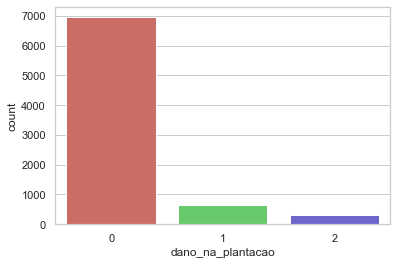

In [553]:
#Podemos visualizar os dados desta previsão:
previsoes['dano_na_plantacao'].value_counts()

sns.countplot(x='dano_na_plantacao',data=previsoes,palette='hls')
plt.show()

In [554]:
#O resultado da previsão do algoritmo construído é:

print('As previsões para a Safra de 2020 utilizando uma regressão logística multiclasses'
      ' com correção de desbalanços via SMOTE \nsugerem que em 2020, {} colheitas estarão saudáveis,' 
      '{} colheitas sofrerão danos gerados pelos pesticidas e {} colheitas sofrerão danos por outros motivos'
      .format(len(previsoes[previsoes['dano_na_plantacao']==0]),
              len(previsoes[previsoes['dano_na_plantacao']==2]),
              len(previsoes[previsoes['dano_na_plantacao']==1])))

p_0=100*len(previsoes[previsoes['dano_na_plantacao']==0])/7913
p_1=100*len(previsoes[previsoes['dano_na_plantacao']==1])/7913
p_2=100*len(previsoes[previsoes['dano_na_plantacao']==2])/7913

print('\nNoutras palavras,{:.2f}% das colheitas estarão saudáveis, {:.2f}% das colheitas sofrerão danos por motivos diversos e {:.2f}% das colheitas sofrerão danos por pesticidas'.format(p_0,p_1,p_2))

As previsões para a Safra de 2020 utilizando uma regressão logística multiclasses com correção de desbalanços via SMOTE 
sugerem que em 2020, 6955 colheitas estarão saudáveis,327 colheitas sofrerão danos gerados pelos pesticidas e 631 colheitas sofrerão danos por outros motivos

Noutras palavras,87.89% das colheitas estarão saudáveis, 7.97% das colheitas sofrerão danos por motivos diversos e 4.13% das colheitas sofrerão danos por pesticidas


# Aprimorando Acurácia e F_1-Score com Gradient Boosting

Embora nosso resultado com a regressão logística multiclasses tenha sido razoável, nosso interesse está em buscar melhores previsões. Para isso, faremos uso do Gradient Boosting.

In [596]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,f1_score

#Vamos implementar o gradient boosting e usar o set de cross-validation para determinar os hiper-parâmetros do modelo
gb=GradientBoostingClassifier(n_estimators=200, learning_rate=0.5)
gb.fit(bal_X, bal_y.values.ravel())

GradientBoostingClassifier(learning_rate=0.5, n_estimators=200)

In [597]:
#Vejamos a acurácia de nosso novo modelo de boosting:
y_predi = gb.predict(X_cv)
print('A acurácia do algoritmo no set de cross-validation é: {:.2f}'
      .format(metrics.accuracy_score(y_cv, y_predi,normalize=True, sample_weight=None)))

A acurácia do algoritmo no set de cross-validation é: 0.84


In [598]:
#Vejamos também nossa nova confusion matrix: É NÍTIDA a diferença nos novos casos 
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_cv, y_predi)
print(confusion_matrix)

[[28824  1019   184]
 [ 3458  1312   226]
 [  579   195   175]]


In [599]:
#Enfim, vejamos nossos F_1-score:
from sklearn.metrics import f1_score
f1w=f1_score(y_cv,y_predi,average='weighted')
f1m=f1_score(y_cv,y_predi,average='micro')

print('Os F_1-Score weighted e micro são, respectivamente, {:.2f} e {:.2f}'.format(f1w,f1m))

Os F_1-Score weighted e micro são, respectivamente, 0.82 e 0.84


Percebemos que o Gradient Boosting Classifier produz melhorias nítidas na confiabilidade da previsão de nosso algoritmo, com acurácia e F_1-Scores próximos de 85%

## Aplicando o Gradient Boosting no nosso set de teste:

In [605]:
#Vejamos a acurácia de nosso novo modelo de boosting:
y_predi = gb.predict(X_t)
print('A acurácia do algoritmo de Gradient Boosting multiclasses no set de teste é: {:.2f}'
      .format(metrics.accuracy_score(y_t, y_predi,normalize=True, sample_weight=None)))

A acurácia do algoritmo de Gradient Boosting multiclasses no set de teste é: 0.83


In [606]:
#Vejamos também nossa nova confusion matrix:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_t, y_predi)
print(confusion_matrix)

[[28675  1125   172]
 [ 3656  1169   254]
 [  560   223   139]]


In [607]:
#Enfim, vejamos nossos F_1-score:
from sklearn.metrics import f1_score
f1w=f1_score(y_t,y_predi,average='weighted')
f1m=f1_score(y_t,y_predi,average='micro')


print('Os F_1-Score weighted e micro são, respectivamente, {:.2f} e {:.2f}'.format(f1w,f1m))

Os F_1-Score weighted e micro são, respectivamente, 0.81 e 0.83


## Previsões para a Safra de 2020 via Gradient Boosting e visualização dos dados

In [614]:
#Fazemos a previsão via Gradient Boosting:
X_novo=safra_prev.drop(columns=['dano_na_plantacao'])
X_novo['dano_na_plantacao']=gb.predict(X_novo)

In [647]:
#Podemos visualizar os dados desta previsão:
resultados=list(X_novo['dano_na_plantacao'].value_counts())
gradfinal=pd.DataFrame({'Categoria':['Saudável','Danos por motivos diversos','Danos por pesticidas'],'Quantidade':resultados})
gradfinal

,Categoria,Quantidade
0,Saudável,7104
1,Danos por motivos diversos,795
2,Danos por pesticidas,14


Obrigado pelo seu tempo!
